In [1]:
import os
import time
import pickle
import itertools
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gaussian_preact
from gaussian_preact import ActivationFunction, ActivationFunctionPos, sampler_normal, build_sampler_weibull
from gaussian_preact.post_process import build_color, build_label, build_linestyle

torch.set_default_dtype(torch.float64)

plt.rcParams['text.usetex'] = 'True'
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]
path_objects = './objects/'

#lst_theta = [2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]    # extensive
lst_theta = [2.05, 2.50, 3.00, 4.00, 5.00, 7.00, 10.00]    # as in the paper
#lst_theta = [2.11]    # for testing
lst_act_types = ['odd', 'pos']

# Preliminary loads and plots

In [4]:
# Load the activation functions
dct_activations = {}
for theta in lst_theta:
    dct = torch.load(path_objects + 'ActFunction_theta-{:.2f}.pkl'.format(theta), weights_only = False)
    dct_activations[('odd', theta)] = dct['activation']
    
    dct = torch.load(path_objects + 'ActFunctionPos_theta-{:.2f}.pkl'.format(theta), weights_only = False)
    dct_activations[('pos', theta)] = dct['activation']
dct_activations["relu"] = torch.relu
dct_activations["tanh"] = torch.tanh

# Create initialization distributions
dct_samplers = {}
for theta in lst_theta:
    dct_samplers[theta] = build_sampler_weibull(theta)
dct_samplers["relu"] = sampler_normal
dct_samplers["tanh"] = sampler_normal

# Create sigma_w
dct_sigma_w = {"relu": 1.4142135623730951, "tanh": 1.2083045973594573}
dct_sigma_b = {"relu": 0., "tanh": 0.11401754250991379}

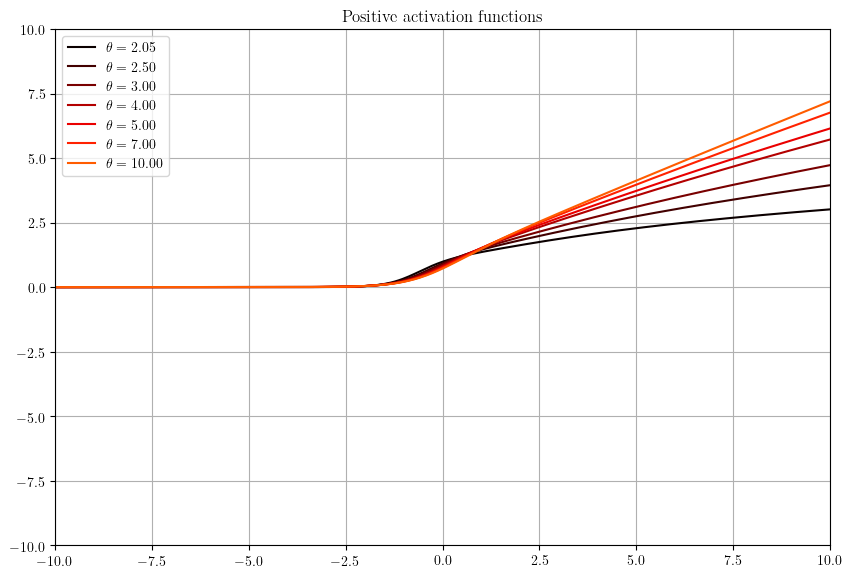

In [5]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]

tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations['pos', theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Positive activation functions')
plt.show()

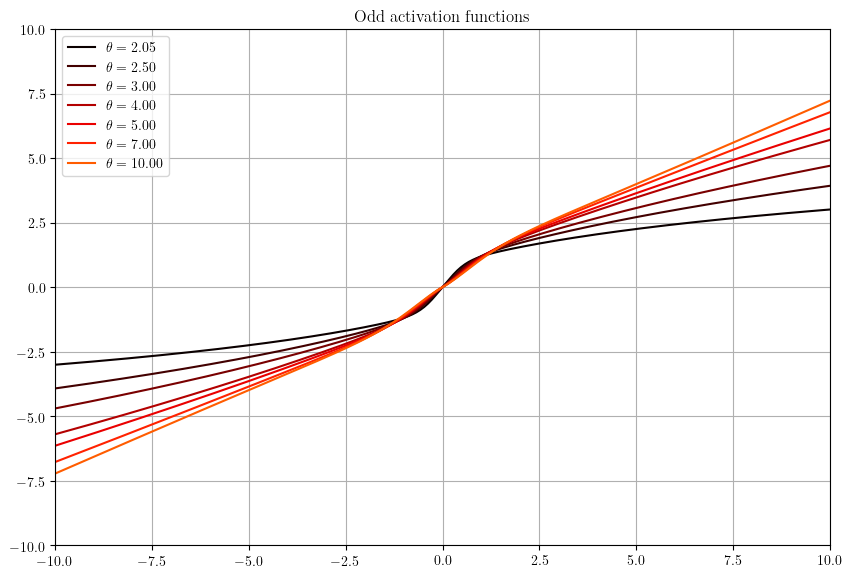

In [6]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]

tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations['odd', theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = build_color({'act_function': 'weibull', 'act_theta': theta}))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Odd activation functions')
plt.show()

# Test gaussianity

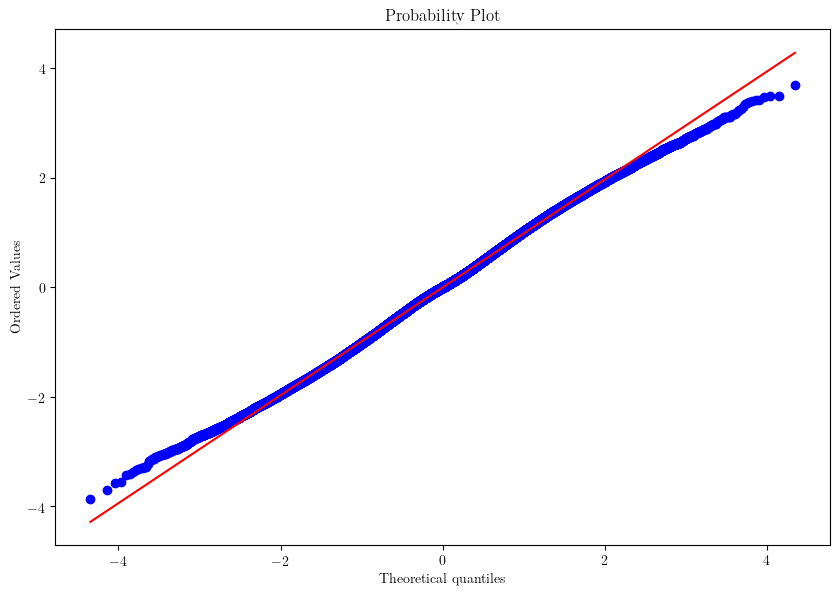

In [7]:
# Rapid test of gaussianity in a simple case: 
# Z = W * phi(X), where X is Gaussian

matplotlib.rcParams['figure.figsize'] = [10, 6.7]

n_samples = 100000
theta = 10

activation = dct_activations['odd', theta]
sampler_weibull = dct_samplers[theta]

z_in = torch.randn(n_samples)
x = activation(z_in)
w = sampler_weibull([n_samples])
z_out = x * w

_ = stats.probplot(z_out, dist = 'norm', plot = plt)
plt.show()

## KS-statistic for a 2-layer neural network

*Minimal model with dependence between pre-activations.*

TODO: documentation

### Computation

In [14]:
def propagate(x, out_dim, sampler, sigma_w = 1., sigma_b = 0.):
    w = sampler([x.size(0), out_dim, x.size(1)], device = x.device, dtype = x.dtype)
    w.mul_(sigma_w)
    ret = torch.bmm(w, x.unsqueeze(2)).squeeze() / np.sqrt(x.size(1))
    if ret.dim() == 1:
        ret = ret.unsqueeze(1)
    if sigma_b != 0.:
        ret += sigma_b * sampler([x.size(0), out_dim], device = x.device, dtype = x.dtype)
    
    return ret

def full_propagation(x, lst_nl, sampler, activation, sigma_w = 1., sigma_b = 0.):
    for i, nl in enumerate(lst_nl):
        if i == 0:
            sampler_ = sampler_normal
        else:
            sampler_ = sampler
        z = propagate(x, nl, sampler_, sigma_w, sigma_b)
        x = activation(z)
    
    return z[:,0]

In [10]:
sigma_w = 1.
n_samples = 200000

lst_nb_neur = list(range(1, 11))
in_dim = 1

In [15]:
def build_lst_nl(idx_ks, n):
    if idx_ks == 0:
        return [1, n, 1]
    elif idx_ks == 1:
        return [n, 2, 1]
    elif idx_ks == 2:
        return [n, n, 1]
    else:
        raise IndexError(f'Index "idx_ks" should be in [0, 2], got {idx_ks}.')

In [9]:
lst_ks = []

for idx_ks in range(3):
    dct_ks = {}
    for act_type, theta in itertools.product(lst_act_types, lst_theta):
        dct_ks[(act_type, theta)] = []
        for n in lst_nb_neur:
            lst_nl = build_lst_nl(idx_ks, n)
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[theta], dct_activations[act_type, theta])
            dct_ks[act_type, theta].append(stats.kstest(z, stats.norm.cdf)[0])

    for act_function in ["relu", "tanh"]:
        dct_ks[act_function] = []
        for n in lst_nb_neur:
            lst_nl = build_lst_nl(idx_ks, n)
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[act_function], dct_activations[act_function],
                                sigma_w = dct_sigma_w[act_function], sigma_b = dct_sigma_b[act_function])
            dct_ks[act_function].append(stats.kstest(z, stats.norm.cdf)[0])
    
    lst_ks.append(dct_ks)

In [16]:
for idx_ks in range(3):
    dct_ks = lst_ks[idx_ks]
    for act_function in ["relu", "tanh"]:
        dct_ks[act_function] = []
        for n in lst_nb_neur:
            lst_nl = build_lst_nl(idx_ks, n)
    
            x_in = torch.ones(1, in_dim).expand(n_samples, in_dim)
            z = full_propagation(x_in, lst_nl, dct_samplers[act_function], dct_activations[act_function],
                                sigma_w = dct_sigma_w[act_function], sigma_b = dct_sigma_b[act_function])
            dct_ks[act_function].append(stats.kstest(z, stats.norm.cdf)[0])

In [18]:
torch.save(lst_ks, 'Data_Init_KS_2layerNN_stat.pkl')

### Plots

In [19]:
sigma_w = 1.
n_samples = 200000

lst_nb_neur = list(range(1, 11))
in_dim = 1

In [25]:
lst_ks = torch.load('Data_Init_KS_2layerNN_stat.pkl', weights_only = False)

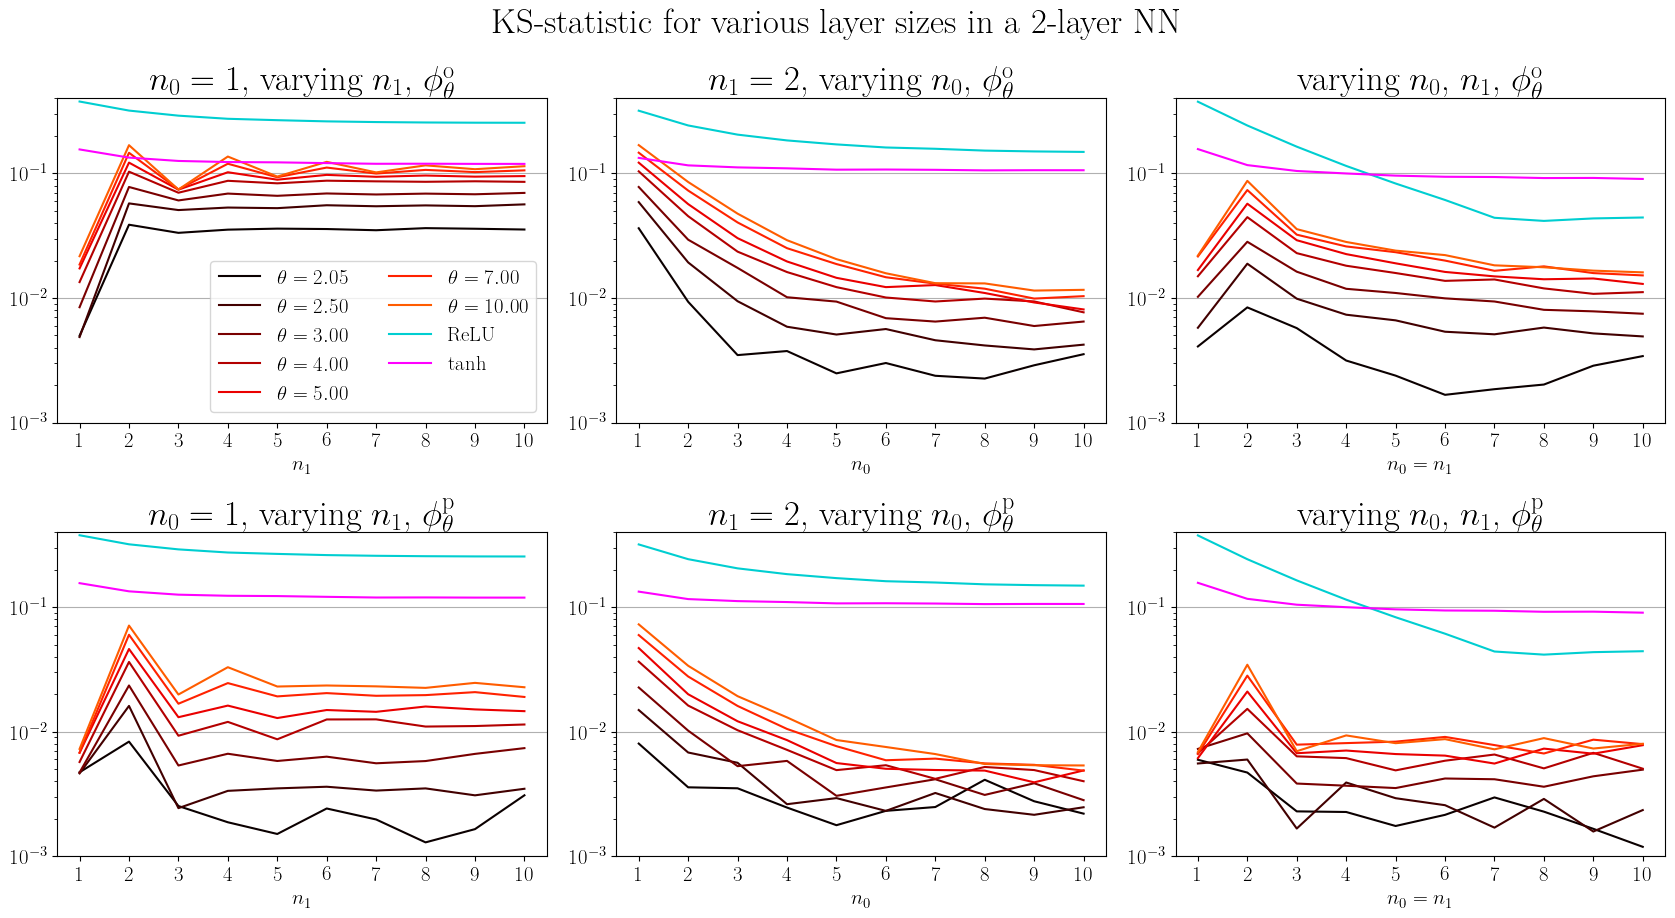

In [26]:
# Prepare the plots
matplotlib.rcParams['figure.figsize'] = [17, 9.4]
matplotlib.rc('font', size = 15, weight = 'normal')
titlesize = 25

y_min, y_max = 1e-3, 4e-1

figure, axis = plt.subplots(2, 3)

# Set up some variables
def build_title_ks(idx_ks, act_type):
    if act_type == "pos":
        name_act = "$\\phi_{\\theta}^{\\mathrm{p}}$"
    else:
        name_act = "$\\phi_{\\theta}^{\\mathrm{o}}$"
        
    if idx_ks == 0:
        return f'$n_0 = 1$, varying $n_1$, {name_act}'
    elif idx_ks == 1:
        return f'$n_1 = 2$, varying $n_0$, {name_act}'
    elif idx_ks == 2:
        return f'varying $n_0$, $n_1$, {name_act}'
    else:
        raise IndexError(f'Index "idx_ks" should be in [0, 2], got {idx_ks}.')

def build_label_x(idx_ks):
    if idx_ks == 0:
        return '$n_1$'
    elif idx_ks == 1:
        return '$n_0$'
    elif idx_ks == 2:
        return '$n_0 = n_1$'
    else:
        raise IndexError(f'Index "idx_ks" should be in [0, 2], got {idx_ks}.')

for idx_ks, dct_ks in enumerate(lst_ks):
    for idx, act_type in enumerate(['odd', 'pos']):
        for theta in lst_theta:
            axis[idx, idx_ks].plot(list(range(1, 11)), dct_ks[act_type, theta], label = r'$\theta = {:.2f}$'.format(theta),
                    c = build_color({'act_function': 'weibull', 'act_theta': theta}))
            
        axis[idx, idx_ks].set_title(build_title_ks(idx_ks, act_type), fontsize = titlesize)
        
        axis[idx, idx_ks].set_yscale('log')
        axis[idx, idx_ks].set_ylim(y_min, y_max)
        
        axis[idx, idx_ks].set_xlabel(build_label_x(idx_ks))
        axis[idx, idx_ks].set_xticks(lst_nb_neur)

        for act_function in ["relu", "tanh"]:
            axis[idx, idx_ks].plot(list(range(1, 11)), dct_ks[act_function], 
                                   label = build_label({"act_function": act_function, "act_theta": 0.}),
                                   c = build_color({'act_function': act_function, 'act_theta': 0.}))

for i in range(2):
    for j in range(3):
        axis[i, j].grid(axis = 'y')

axis[0,0].legend(ncol = 2)

# Global title
plt.suptitle('KS-statistic for various layer sizes in a 2-layer NN', fontsize = titlesize)

plt.tight_layout()
plt.savefig('Plot_Init_KS_2layerNN.pdf')
plt.show()